Import relevant libraries

In [73]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
pip install tqdm

In [75]:
pip install pydicom

In [76]:
# pip install -U albumentations

In [77]:
import tensorflow as tf

In [78]:
%tensorflow_version 2.x
%matplotlib inline

In [79]:
import random
from glob import glob
import os
import time
import math

from zipfile import ZipFile
from tqdm import tqdm

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom as dicom

from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import Conv2D, Input, Flatten, Dense, Dropout, Concatenate, BatchNormalization, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy


In [80]:
rootDir='drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/'
zipFilename=rootDir+'rsna-pneumonia-detection-challenge.zip'
datasetPath=rootDir+'rsna-pneumonia-detection-challenge/'


In [81]:
if os.path.exists(zipFilename):
    if not os.path.exists(datasetPath):
      with ZipFile(zipFilename, 'r') as zip:
        zip.extractall(datasetPath)

The input folder contains 4 important information
* stage_2_train_labels.csv - CSV file containing the patient id, bounding boxes and target label
* stage_2_detailed_class_info.csv - CSV file containing the detail informaiton of patientid and the corresponding label
* stage_2_train_images - directory contains train images in DICOM format
* stage_2_test_images - directory contains test images in DICOM format

In [82]:
trainImagesDir=datasetPath+'stage_2_train_images/'
testImagesDir=datasetPath+'stage_2_test_images/'
sampleSubmission=datasetPath+'stage_2_sample_submission.csv'
classInfo=datasetPath+'stage_2_detailed_class_info.csv'
rsnaLink=datasetPath+'GCP Credits Request Link - RSNA.txt'
trainLabels=datasetPath+'stage_2_train_labels.csv'


In [83]:
images_path=glob(trainImagesDir + '*.dcm')
if len(images_path)==0:
  images_path=glob(trainImagesDir + '*.dcm')
print('Total number images in the training set are {}'.format(len(images_path)))
for name in random.sample(images_path, 5):
    print(name)

Total number images in the training set are 26683
drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/stage_2_train_images/4abcd328-2c19-4bd8-a102-e0320fde2b10.dcm
drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/stage_2_train_images/59a85e75-e2d3-4840-86f8-9573bc8499bc.dcm
drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/stage_2_train_images/d07723af-1804-40ed-8eae-b977440e193d.dcm
drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/stage_2_train_images/0c58209f-4484-4be8-a687-c8a1419aefcb.dcm
drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/stage_2_train_images/d73509a6-c0c2-4c8a-8e41-4c58eecfc035.dcm


The image names are stored with patientId

In [84]:
image_target=pd.read_csv(trainLabels)
image_target.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


The CSV file contains PatientId, bounding box details with (x,y) coordinates and width and height that encapsulates the box. It also contains the Target variable. For target variable 0, the bounding box values has NaN values.


In [85]:
print(image_target.shape)

(30227, 6)


There are only 26684 images in the image directory, but the csv file contains 30227 rows. There are more rows than the images, which indicates there are duplicate entries for patientId

We can observe row #4 and #5, row #8 and #9 have same patientId values, aka, the patient is identified with pneumonia at multiple areas

In [86]:
image_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


For the info of the data, we observe that of the total 30227 rows, 9555 rows has non null. So, all bounding boxes are either defined or not defined.

In [87]:
print(image_target[image_target.Target==0].shape[0])
print(image_target[image_target.Target==1].shape[0])

20672
9555


We see from above that the total number of patientIds that are identified with Pneumonia are 9555 and it matches to the non null values. It can be inferred from this that all pneumonia data set has bounding boxes defined and for normal patients, no bounding boxes exist.

In [88]:
image_target.Target.unique()

array([0, 1])

The target has two classifications 0 and 1 namely Normal and Pneumonia

In [89]:
def update_dataset(path, df1):
    pid=[]
    label=[]
    bbox=[]

    for name, group in df1.groupby(['patientId','Target']):
        pid.append(path+group['patientId'].tolist()[0]+'.dcm')
        label.append(group['Target'].tolist()[0])
        if group['Target'].tolist()[0] == 1:
            ibbox=[]
            for row in group.iterrows():
                ibbox.append([row[1]['x'], row[1]['y'], row[1]['width'], row[1]['height']])
            bbox.append(ibbox)
        else:
            bbox.append([])
    df = pd.DataFrame({'patientId':pid, 'bboxes': bbox, 'label':label})
    return df

We can observe that the non-null values are 9555 which matches to the patients that have pneumonia problem

In [90]:
df=update_dataset(trainImagesDir, image_target)
print(df.shape)
df.head()

(26684, 3)


,patientId,bboxes,label
0,drive/.shortcut-targets-by-id/1VWK20mbevRp-chF...,[],0
1,drive/.shortcut-targets-by-id/1VWK20mbevRp-chF...,[],0
2,drive/.shortcut-targets-by-id/1VWK20mbevRp-chF...,"[[316.0, 318.0, 170.0, 478.0], [660.0, 375.0, ...",1
3,drive/.shortcut-targets-by-id/1VWK20mbevRp-chF...,"[[570.0, 282.0, 269.0, 409.0], [83.0, 227.0, 2...",1
4,drive/.shortcut-targets-by-id/1VWK20mbevRp-chF...,"[[66.0, 160.0, 373.0, 608.0], [552.0, 164.0, 3...",1


In [91]:
print('Total number of patients that are normal are {}'.format(df[df.label==0].shape[0]))
print('Total number of patients that have pneumonia are {}'.format(df[df.label==1].shape[0]))

Total number of patients that are normal are 20672
Total number of patients that have pneumonia are 6012


In [92]:
imgWidth=224
imgHeight=224
imgChannels=3
imgSize=(imgHeight, imgWidth)
batchSize=64
labelDict={0:'normal', 1:'lung opacity'}

In [93]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except ValueError:
#     strategy = tf.distribute.get_strategy() # for CPU and single GPU
#     print('Number of replicas:', strategy.num_replicas_in_sync)

In [94]:
print('Maximum number of areas detected for Pneumonia are {}'.format(max([len(x) for x in df.bboxes])))

Maximum number of areas detected for Pneumonia are 4


In [95]:
def loadImage(row, axis):
    image_path = row.patientId
    img = dicom.dcmread(image_path).pixel_array
    axis.imshow(img, cmap='gray')
    lbl=labelDict.get(row.label)
    bboxes=row.bboxes
    for bbox in bboxes:
        x=bbox[0]
        y=bbox[1]
        w=bbox[2]
        h=bbox[3]
        rect = patches.Rectangle((x,y), w, h, linewidth=2, edgecolor='red', fill=False)
        axis.add_patch(rect)
    axis.set_title(lbl)
    

In [96]:
def loadImages(df):
    cols=5
    rows=4
    idx=0
    f,axarr=plt.subplots(rows,cols,figsize=(18,10))
    for r in range(rows):
        for c in range(cols):
            axis=axarr[r,c]
            loadImage(df.iloc[idx], axis)
            idx+=1
    plt.tight_layout()

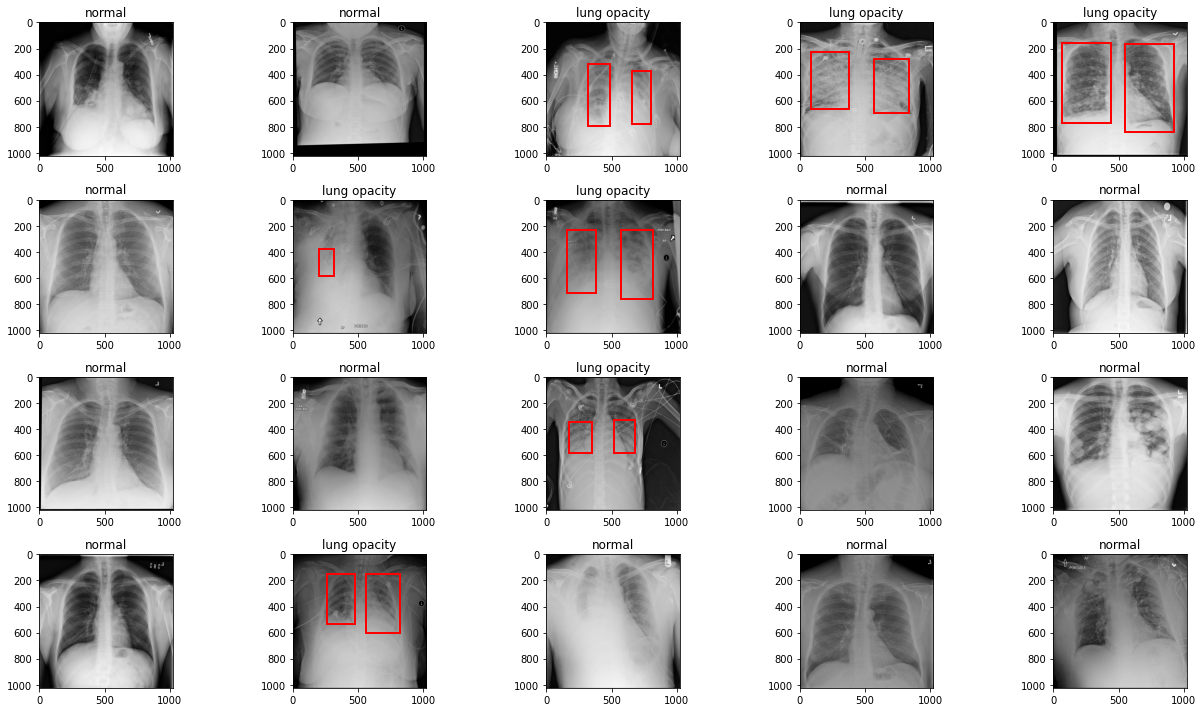

In [97]:
loadImages(df)

Let us print the image with maximum bounding boxes

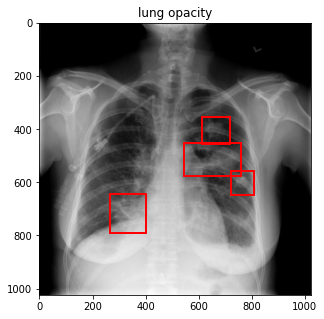

In [98]:
max_bbox_idx=np.argmax([len(x) for x in df.bboxes])
f,axarry=plt.subplots(1,1,figsize=(5,5))
loadImage(df.iloc[max_bbox_idx], axarry)

In [99]:
def check_images_shape(path):
    img_path=glob(path + '*.dcm')
    imagesShape=[dicom.dcmread(image).pixel_array.shape for image in tqdm(img_path)]
    print(set(imagesShape))


In [100]:
# with strategy.scope():
# check_images_shape(trainImagesDir)

All the images are of size 1024*1024

Even though the size of the images are same, we can observe the image inside have different aspect ratio, that is, not all images occupy the same space. Also, the brightness is different.

In [101]:
c=math.ceil(df.shape[0]*0.7)
train_df,val_df=df[:c],df[c:]
print(train_df.shape, val_df.shape)

(18679, 3) (8005, 3)


In [102]:
class CustomDataGen(Sequence):
    
    def __init__(self, df, x_col, y_col, batch_size, input_size=(224, 224, 3), preprocess_function=None, shuffle=True, predict=False):
        self.df = df.copy(deep=True)
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.predict = predict
        self.n = len(self.df)
        self.n_class = df[y_col['output1']].nunique()
        self.preprocess_function=preprocess_function
    
    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self.df.patientId)
    
    def __loadinput(self, img_path, bboxes):
        image = dicom.dcmread(img_path).pixel_array
        img_size = (image.shape[0],image.shape[1])
        image = cv2.resize(image,(self.input_size[0], self.input_size[1]))
        if len(image.shape) !=3 or image.shape[2]!=3:
          image = np.stack([image] * 3, axis=2)
        # Will add data augmenting technique
        if self.preprocess_function != None:
            image = self.preprocess_function(image)
        if self.predict:
          return image
        else:
          mask = np.zeros((self.input_size[0], self.input_size[1]))
          for bbox in bboxes:
                x, y, w, h = bbox
                x1=math.floor(x*self.input_size[1]/img_size[1])
                y1=math.floor(y*self.input_size[0]/img_size[0])
                x2=math.ceil((x+w)*self.input_size[1]/img_size[1])
                y2=math.ceil((y+h)*self.input_size[0]/img_size[0])
                mask[y1:y2, x1:x2] = 1
          return image, mask

    
    def __loaddata(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.x_col['input']]
        class_batch = batches[self.y_col['output1']]
        bboxes_batch = batches[self.y_col['output2']]

        img_batch = [self.__loadinput(filename, bboxes) for filename, bboxes in zip(path_batch, bboxes_batch)]

        return img_batch
    
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        batchdata = self.__loaddata(batches)
        if self.predict:
            return batchdata
        else:
            image, mask = zip(*batchdata)
            return np.array(image), np.array(mask)

    def __len__(self):
        return self.n // self.batch_size


In [103]:
traingen = CustomDataGen(train_df[:500],
                          x_col={'input':'patientId'},
                          y_col={'output1': 'label', 'output2': 'bboxes'},
                          batch_size=batchSize, input_size=(imgSize),
                          preprocess_function=preprocess_input
                        )

valgen = CustomDataGen(val_df[:350],
                          x_col={'input':'patientId'},
                          y_col={'output1': 'label', 'output2': 'bboxes'},
                          batch_size=batchSize, input_size=(imgSize),
                          preprocess_function=preprocess_input
                        )


In [104]:
def create_vgg16_unetmodel():
    print('Creating VGG16 model')
    model = VGG16(input_shape=(imgHeight, imgWidth, 3), include_top=False, weights="imagenet")
    for layer in model.layers:
        layer.trainable = False

    #encoder - get output layers for concatenate with the upsampling layer
    block1 = model.get_layer("block1_conv2").output
    block2 = model.get_layer("block2_conv2").output
    block3 = model.get_layer("block3_conv3").output
    block4 = model.get_layer("block4_conv3").output
    block5 = model.get_layer("block5_conv3").output
    # block6 = model.get_layer("block5_pool").output

    #Decoder block
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (block5)
    x = Concatenate()([x, block4])
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)
    x=Dropout(0.5)(x)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
    x = Concatenate()([x, block1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
    x= BatchNormalization()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    vgg16unetmodel = Model(inputs=model.input, outputs=x)
    
    return vgg16unetmodel


In [105]:
model=create_vgg16_unetmodel()
model.summary()

Creating VGG16 model
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
_______________________________________________________________________

In [106]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon()) # adding epsilon to avoid number divide by zero exception

def dicecoeffloss(y_true, y_pred):
    return 0.0*binary_crossentropy(y_true, y_pred) - K.log(dice_coefficient(y_true, y_pred) + K.epsilon())
    

In [107]:
model_path=datasetPath+"model_bathi.h5"
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True)
stop = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)
adam=Adam(learning_rate=0.01, beta_1=0.9,beta_2=0.999)
model.compile(loss=dicecoeffloss, optimizer=adam, metrics=[dice_coefficient])

In [108]:
try:
    start=time.time()
    model.fit(  traingen,
                validation_data = valgen,
                epochs=50,
                batch_size=64,
                callbacks=[stop, reduce_lr, checkpoint]
            )
    print('Time taken:',time.time()-start)
except Exception as e:
    print(e)

Epoch 1/50
7/7 [==============================] - 126s 18s/step - loss: 2.0264 - dice_coefficient: 0.1417 - val_loss: 16.1089 - val_dice_coefficient: 9.3073e-10

Epoch 00001: val_loss improved from inf to 16.10887, saving model to drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/model.h5
Epoch 2/50
7/7 [==============================] - 20s 3s/step - loss: 1.7517 - dice_coefficient: 0.1827 - val_loss: 4.3225 - val_dice_coefficient: 0.0141

Epoch 00002: val_loss improved from 16.10887 to 4.32247, saving model to drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pneumonia-detection-challenge/model.h5
Epoch 3/50
7/7 [==============================] - 20s 3s/step - loss: 1.6140 - dice_coefficient: 0.2094 - val_loss: 1.7314 - val_dice_coefficient: 0.1824

Epoch 00003: val_loss improved from 4.32247 to 1.73138, saving model to drive/.shortcut-targets-by-id/1VWK20mbevRp-chFTg9xT_xE_TF59l_IY/Capstone/rsna-pn